In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from load_data import _PyLasaDataSet
DataSet = _PyLasaDataSet()

Using LASA DataSet from /home/oem/Desktop/UCL/ILoSA/example/DataSet


In [3]:
def var_gradient(pos, lscale, training_pos, krnl_, K_inv): #this is the derivative of the RBF kernel
    pos = pos.reshape(1, 2)
    k_star = krnl_(training_pos, pos).reshape(-1, 1)
    dKdx = -k_star * (training_pos[:, 0].reshape(-1, 1) - pos[0][0]) / (lscale[0] ** 2)
    dKdy = -k_star * (training_pos[:, 1].reshape(-1, 1) - pos[0][1]) / (lscale[1] ** 2)
    a = -2 * np.matmul(np.transpose(k_star), K_inv)
    dSigma_dx_ = np.matmul(a, np.reshape(dKdx, [len(a[0]), 1]))
    dSigma_dy_ = np.matmul(a, np.reshape(dKdy, [len(a[0]), 1]))
    return float(dSigma_dx_), float(dSigma_dy_)

### Load the dataset

In [4]:
angle_data = DataSet.BendedLine
demos = angle_data.demos # list of 7 Demo objects, each corresponding to a 
                         # repetition of the pattern
downsample=10
X=np.transpose(demos[0].pos[:,100::downsample]) 
X_dot=np.zeros((len(X),2))
for j in range(len(X)-1): 
    X_dot[j,:]=(X[j+1,:]-X[j,:])
ind=range(1,5)
for i in ind:
    X_traj=np.transpose(demos[i].pos[:,100::downsample])
    X=np.vstack((X, X_traj))
    X_dot_traj=np.zeros((len(X_traj),2))
    for j in range(len(X_traj)-1): 
        X_dot_traj[j,:]=np.transpose(X_traj[j+1,:]-X_traj[j,:])
    X_dot=np.vstack((X_dot, X_dot_traj))  

### Let's initialize and train a Gaussian Process
Please notice that we are using a Matern kernel rather than an RBF kernel

In [5]:
#k = C(constant_value=np.sqrt(0.1))  * RBF(1*np.ones(2)) + WhiteKernel(0.01 )
k = C(constant_value=np.sqrt(0.1))  * Matern(1*np.ones(2), nu=1.2) + WhiteKernel(0.01 ) #this kernel works sooo much better!

gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=5)
gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=5)
gp.fit(X,X_dot)

gp_kernels_ = gp.kernel_
kernel_params_ = [gp_kernels_.get_params()['k1__k2__length_scale'], gp_kernels_.get_params()['k1']]
noise_var_ = gp.alpha + gp_kernels_.get_params()['k2__noise_level']
K_ = gp_kernels_(X, X) + (noise_var_ * np.eye(len(X)))
K_inv = np.linalg.inv(K_)

### Let's define a grid where to evaluate the learned dynamical system 

In [6]:
x_grid=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y_grid=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x_grid, y_grid)
u=np.ones((len(x_grid),len(y_grid)))
v=np.ones((len(x_grid),len(y_grid)))

### Let's plot the prediction with a vanilla Matern GP <ins>without</ins> stabilization vector

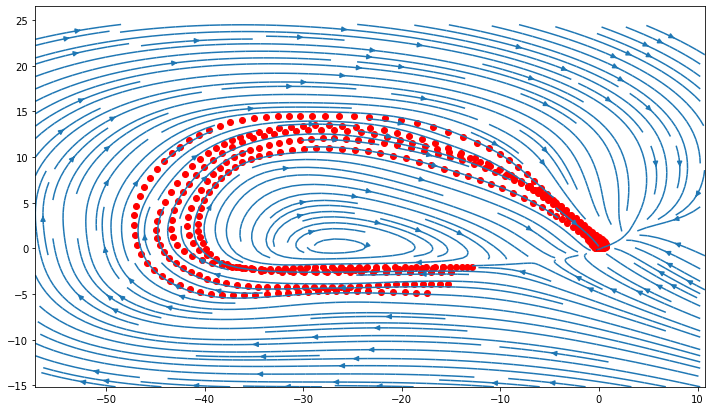

In [7]:
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        x=np.array([XX[i,j],YY[i, j]])
        [vel, var]=gp.predict(x.reshape(1,-1), return_std=True)
        u[i,j]=vel[0][0]
        v[i,j]=vel[0][1]
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2)
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plt.show() 

### Let's plot the prediction with a vanilla Matern GP <ins>with</ins> stabilization vector.
Please notice that we are only getting the direction for the stabilization but the magnitude is set a 2 times the standard deviation of the GP. This is slighly different from the paper but it ensures that the effect of the gradint does not vanish. 

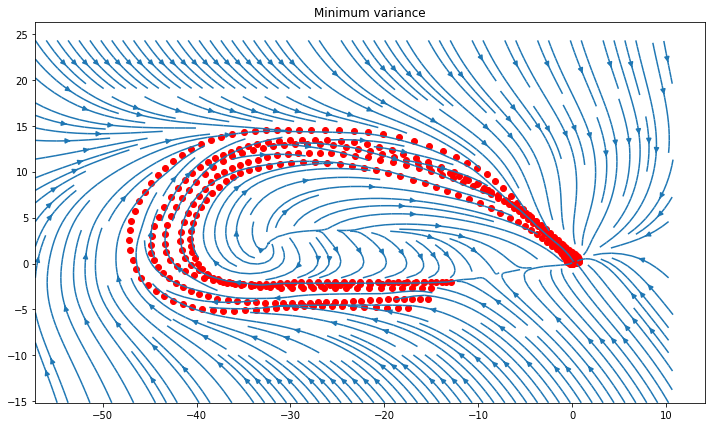

In [8]:
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)
        [vel, std]=gp.predict(pos, return_std=True)
        grad=var_gradient(pos, kernel_params_[0], X, gp_kernels_ , K_inv )
        u[i,j]=vel[0][0]+2*std[0]*grad[0]/np.sqrt(grad[0]**2+grad[1]**2)
        v[i,j]=vel[0][1]+2*std[0]*grad[1]/np.sqrt(grad[0]**2+grad[1]**2)

fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2)
plt.scatter(X[:,0],X[:,1], color=[1,0,0]) 
plt.title("Minimum variance")
plt.show()

# Which is your fovourite? 
Let me know at g.franzese@tudelft.nl